In [1]:
# Import libraries
%matplotlib inline

import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale

sns.set(style="whitegrid")

/Users/shannagreathouse/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [7]:
import pysal as ps

In [35]:
# Import data
broker_data = 'data/Brokered2018_zipcodes.csv'
coord = 'data/states.json'


In [36]:
# Read data
broker = pd.read_csv(broker_data)
broker.head()

,Order #,Leg #,Start Date,Agent Office,Cust ID,Customer,Carrier ID,Carrier,Origin City,Origin State,Destination City,Destination State,Brokered Revenue,Carrier Pay,Brokered Margin,Brokered Margin %,Booking Agent ID,Booking Agent
0,1361713,1349039,8/15/18,1,AMNP,AMNP,43708,43708,San Antonio,TX,Palmyra,WI,"$2,500.00","$2,400.00",$100.00,4.00%,KAILA,1
1,1501026,1542730,1/30/18,1,AMNP,AMNP,442007,442007,Hammond,IN,Denver,CO,"$3,050.00","$2,950.00",$100.00,3.27%,KAILA,1
2,1518714,1567360,1/5/18,1,AMNP,AMNP,971955,971955,Denver,CO,Meridian,ID,"$1,200.00","$1,200.00",$-,0.00%,ZABCA,2
3,1538821,1595101,4/2/18,1,AMNP,AMNP,355478,355478,Jewett,TX,Hartford,SD,"$2,000.00","$1,900.00",$100.00,5.00%,KAILA,1
4,1601007,1680031,8/22/18,1,AMNP,AMNP,184749,184749,Bismarck,ND,Marion,OH,"$2,300.00","$2,200.00",$100.00,4.34%,KAILA,1


In [37]:
broker['Start Date'] =  pd.to_datetime(broker['Start Date'])

In [38]:
print(broker['Start Date'])

0        2018-08-15
1        2018-01-30
2        2018-01-05
3        2018-04-02
4        2018-08-22
            ...    
213739   2021-05-28
213740   2021-05-28
213741   2021-05-31
213742   2021-05-31
213743   2021-05-31
Name: Start Date, Length: 213744, dtype: datetime64[ns]


In [39]:
# Find the max date in the data set for rolling 12 month
endDate = broker['Start Date'].max()
endDate

Timestamp('2021-05-31 00:00:00')

In [66]:
# Rolling date start point
startDate = endDate - pd.DateOffset(years=1)
startDate

Timestamp('2020-05-31 00:00:00')

In [84]:
#filter out data prior to start date to have rolling 12 months
filteredBroker = broker.loc[(broker['Start Date'] >= startDate)]
filteredBroker.rename(columns = {' Origin City ':'state'}, inplace = False)
filteredBroker

for col in filteredBroker.columns:
    print(col)

,Order #,Leg #,Start Date,Agent Office,Cust ID,Customer,Carrier ID,Carrier,Origin City,Origin State,Destination City,Destination State,Brokered Revenue,Carrier Pay,Brokered Margin,Brokered Margin %,Booking Agent ID,Booking Agent
131033,2039632,2219540,2021-04-27,1,AMNP,AMNP,155298,155298,Saint Paul,MN,Bottineau,ND,"$1,600.00","$1,500.00",$100.00,6.25%,HERRO,4
142166,2069107,2258289,2020-06-19,5,CONELP,CONELP,775727,775727,Heyburn,ID,Council Bluffs,IA,"$2,150.56","$1,700.00",$450.56,20.95%,MELMI,9
144595,2075503,2266726,2020-06-01,17,FAMMAU,FAMMAU,70282,70282,Rolesville,NC,Cowpens,SC,$521.74,$500.00,$21.74,4.16%,OCASO,104
144596,2075504,2266727,2020-06-08,17,FAMMAU,FAMMAU,70282,70282,Rolesville,NC,Cowpens,SC,$521.74,$500.00,$21.74,4.16%,OCASO,104
144598,2075506,2266729,2020-06-08,17,FAMMAU,FAMMAU,673535,673535,Rolesville,NC,Cowpens,SC,$-,$150.00,$(150.00),0.00%,OCASO,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213739,2341809,2586585,2021-05-28,10,MONEAS,MONEAS,TX6877A,TX6877A,Houston,TX,Houston,TX,"$1,200.00","$1,000.00",$200.00,16.66%,QUITHO,39
213740,2347760,2593593,2021-05-28,16,CHICHA,CHICHA,770152,770152,New Castle,DE,Wilmington,DE,$143.96,$-,$143.96,100.00%,UNKNOWN,6
213741,2347761,2593594,2021-05-31,16,CHICHA,CHICHA,770152,770152,New Castle,DE,Wilmington,DE,$143.96,$-,$143.96,100.00%,UNKNOWN,6
213742,2347762,2593595,2021-05-31,16,CHICHA,CHICHA,770152,770152,New Castle,DE,Wilmington,DE,$143.96,$-,$143.96,100.00%,UNKNOWN,6


In [51]:
# Variables maintained
varis = ['Agent Office', 'Customer', 'Booking Agent','Carrier']

In [60]:
#Group data by state
#states = filteredBroker.groupby('Origin State')[varis].sum()
#states.info()
states = filteredbroker.groupby(‘Origin State’)[‘varis’]

SyntaxError: invalid character in identifier (<ipython-input-60-a3cb56448cb6>, line 4)

In [61]:
#types = pd.get_dummies(filteredBroker['Customer'])
#region_types = types.join(filteredBroker['Origin State'])\
                  .groupby('Origin State')\
                  .sum()
#region_types_pct = (region_types * 100.).div(region_types.sum(axis=1), axis=0)
#region_types_pct.info()

IndentationError: unexpected indent (<ipython-input-61-b98c6294f317>, line 3)

In [62]:
#aves_props = aves.join(prop_types_pct)

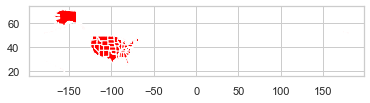

In [63]:
# bring in geojson dataframe
usMap = gpd.read_file(coord)
usMap.plot(color='red');

In [ ]:
# match geojson dataframe and broker_data on 'state'
zdb = usMap[['geometry', 'zipcode', 'name']].join(db, on='zipcode')\
                                         .dropna()

In [ ]:
#aves = zip_data.groupby('zipCode')[varis].mean()
#aves.info()

In [ ]:
db = pd.DataFrame(\
                 scale(aves_props), \
                 index=aves_props.index, \
                 columns=aves_props.columns)\
       .rename(lambda x: str(int(x)))

In [ ]:
zdb = zc[['geometry', 'zipcode', 'name']].join(db, on='zipcode')\
                                         .dropna()

In [ ]:
#Cluster in specfic groups
km5 = cluster.KMeans(n_clusters=5)

In [ ]:
# Fit to data
km5cls = km5.fit(zdb.drop(['geometry', 'name'], axis=1).values)

In [ ]:
# Map clusters
f, ax = plt.subplots(1, figsize=(9, 9))

zdb.assign(cl=km5cls.labels_)\
   .plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

plt.show()

In [ ]:
# Attributes
cl_pcts = prop_types_pct.rename(lambda x: str(int(x)))\
                          .reindex(zdb['zipcode'])\
                          .assign(cl=km5cls.labels_)\
                          .groupby('cl')\
                          .mean()

In [ ]:
#Visualize attributes and mix
f, ax = plt.subplots(1, figsize=(18, 9))
cl_pcts.plot(kind='barh', stacked=True, ax=ax, \
             cmap='Set2', linewidth=0)
ax.legend(ncol=1, loc="right");

In [ ]:
import geopandas as gpd

df = gpd.read_file(r"C:\Users\steph\Desktop\Project 3\State-zip-code-GeoJSON-master\al_alabama_zip_codes_geo.min.json")


In [ ]:
df.head()

In [ ]:
#test code
df.to_file("test", driver="GeoJSON")
df = gpd.read_file(r"test")
df.head()